# Initialization

## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
    
import torchvision.transforms.functional as tF

from models.unet import UNET

from dataset.dataset import seg_datasets

from utils.dataloader_utils import get_loader
from utils.save_load_utils import save_model, load_model
from utils.evaluation_utils import calculate_miou, check_acc
from utils.visualization_utils import save_pred_masks, visualize_segmentation, plot_segmentation
                                                                     
import albumentations as A

from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
import os
import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = False

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


## Hyperparameters

In [2]:
hyperparameters = {
    'test_dir' : './images/test',
    'train_dir' : './images/train',
    'seed' : 9999,
    'dataloader' :{
        'batch_size' : 8,
        'num_workers' : 4,
        'pin_memory' : False, 
    },
    'optimizer' :{
        'lr' : 1e-4,
        'betas' : (0.9, 0.999),
        'weight_decay' : 1e-4,
    },
    'epochs' : 150,
    'training_size' : 0,
    'test_size': 0,
    'gradient_clipping' : 1.0,
    'unet': {
        'in_channels': 3,
        'out_channels': 1,
        'features': 64,
        'height': 320,
        'width': 320,
        'pre_trained_path': 'checkpoints/pretrained/pretrained_best.pth.tar',
    }, 
    'output_dir':{
        'results':'../generated_examples/unet/',
        'model1':'../generated_examples/unet/wc/',
        'model2':'../generated_examples/unet/kd/',
    },
    'checkpoints_dir':{
        'model1': './checkpoints/unet/wc/',
        'model2': './checkpoints/unet/kd/',

    },
}

## Seed Everything

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(hyperparameters['seed'])

# Data Preprocessing

## Data Augmentation

In [4]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

test_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

"""
test_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize(512, antialias=True)
])
"""
train_transforms, test_transforms

(Compose([
   HorizontalFlip(always_apply=False, p=0.5),
   VerticalFlip(always_apply=False, p=0.5),
   Rotate(always_apply=False, p=0.5, limit=(-90, 90), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
   Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
   Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True),
 Compose([
   Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
   Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True))

## Dataset

In [5]:
train_dataset = seg_datasets(hyperparameters['train_dir'], train_transforms)
test_dataset = seg_datasets(hyperparameters['test_dir'], test_transforms)

len(train_dataset), len(test_dataset)

(104, 27)

In [6]:
print(test_dataset.img_files)

['115_Plan.jpg', '119_Plan.jpg', '122_Plan.jpg', '125_Plan.jpg', '126_Plan.jpg', '131_Plan.jpg', '16_Plan.jpg', '17_Plan.jpg', '21_Plan.jpg', '26_Plan.jpg', '40_Plan.jpg', '41_Plan.jpg', '48_Plan.jpg', '4_Plan.jpg', '57_Plan.jpg', '58_Plan.jpg', '63_Plan.jpg', '66_Plan.jpg', '6_Plan.jpg', '73_Plan.jpg', '81_Plan.jpg', '88_Plan.jpg', '8_Plan.jpg', '92_Plan.jpg', '95_Plan.jpg', '98_Plan.jpg', '99_Plan.jpg']


In [7]:
hyperparameters['training_size'] = len(train_dataset)
hyperparameters['test_size'] = len(test_dataset)

In [8]:
sample = train_dataset[30]
torch.unique(sample[1])

tensor([0., 1., 2., 3.])

In [9]:
img, mask = train_dataset[20]
img.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


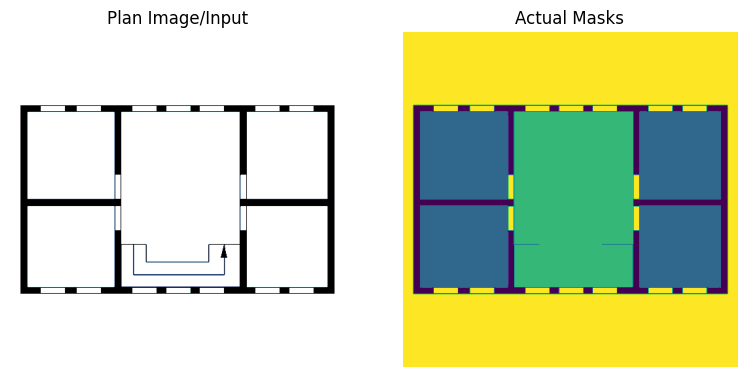

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout()
ax1.axis('off')
ax1.set_title('Plan Image/Input')
ax1.imshow(img.permute(1, 2, 0).numpy())
    
ax2.axis('off')
ax2.set_title('Actual Masks')
ax2.imshow(mask.numpy().transpose(1,2,0))

## Color Mapping

In [11]:
color_mapping = {
    0: (0, 0, 0),         # Walls
    1: (255, 80, 80),     # Iwan
    2: (80, 80, 255),     # Room
    3: (255, 255, 255),   # Background
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

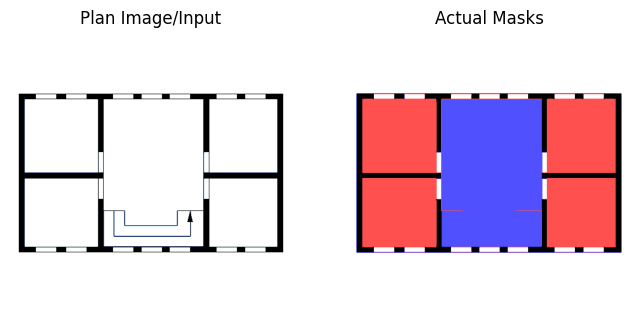

In [12]:
visualization = visualize_segmentation(mask, color_mapping, from_tensor=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.imshow(img.permute(1, 2, 0).numpy())
ax1.set_title('Plan Image/Input')
ax1.axis('off')

ax2.imshow(visualization)
ax2.set_title('Actual Masks')
ax2.axis('off')

## Dataloader

In [13]:
train_dataloader, test_dataloader = get_loader(
    train_dir = hyperparameters['train_dir'],
    test_dir = hyperparameters['test_dir'],
    batch_size = hyperparameters['dataloader']['batch_size'],
    train_transform = train_transforms,
    test_transform = test_transforms,
    num_workers = hyperparameters['dataloader']['num_workers'],
    pin_memory = hyperparameters['dataloader']['pin_memory']
)

len(train_dataloader), len(test_dataloader)

(13, 4)

In [14]:
img_a_batch, img_b_batch = next(iter(train_dataloader))
print(img_a_batch.shape, img_b_batch.shape)
print(img_a_batch.size(0))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])
8


# Model

## Model Loading

In [15]:
"""
model1 --> weight copy
model2 --> knowledge distillation

"""

model1 = UNET(
    features=hyperparameters['unet']['features'], 
    in_channels=hyperparameters['unet']['in_channels'], 
    out_channels=hyperparameters['unet']['out_channels']
)

model2 = UNET(
    features=hyperparameters['unet']['features'], 
    in_channels=hyperparameters['unet']['in_channels'], 
    out_channels=hyperparameters['unet']['out_channels']
)

## Pre-Trained Model Loading

In [16]:
!pip install pretrained-backbones-unet

In [17]:
from backbones_unet.model.unet import Unet

"""
pre_model:
    - weight source for model 1
    - teacher model for model 2
    - weight source and teacher model for model 3
"""

pre_model = Unet(
    backbone='convnext_base', # backbone network name
    in_channels=3,            # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=1,            # output channels (number of classes in your dataset)
)

checkpoint = torch.load(hyperparameters['unet']['pre_trained_path'])
pre_model.load_state_dict(checkpoint['model_state_dict'], strict=True)

pre_model.to(device)

C:\Users\user\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): FeatureListNet(
    (stem_0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_af

## Weight Copy

In [18]:
pretrained_dict = pre_model.state_dict()
model1_dict = model1.state_dict()

new_state_dict1 = {}

for k, v in pretrained_dict.items():
    if k in model1_dict:
        new_state_dict1[k] = v

model1_dict.update(new_state_dict1)
model1.load_state_dict(model1_dict)

<All keys matched successfully>

## Number of Parameters

In [19]:
### Dummy Data
__batch_size = 1
__in_channels = hyperparameters['unet']['in_channels']
__width = hyperparameters['unet']['width']
__height = hyperparameters['unet']['height']

dummy_input = torch.randn((__batch_size, __in_channels, __height, __width))
dummy_out = model1(dummy_input)

print(f'Model input size: {dummy_input.shape}')
print(f'Model output size: {dummy_out.shape}')

Model input size: torch.Size([1, 3, 320, 320])
Model output size: torch.Size([1, 1, 320, 320])


In [20]:
print(f'Number of Parameters: {sum(dummy_out.numel() for p in model1.parameters()):,}')

Number of Parameters: 6,553,600


# Loss & Optimizer

## Loss Function

In [21]:
"""
model1 --> loss_fn (segmentation loss)
model2 --> total_loss (segmentation loss + distillation loss)

"""

'\nmodel1 --> loss_fn (segmentation loss)\nmodel2 --> total_loss (segmentation loss + distillation loss)\n\n'

In [22]:
criterion = nn.MSELoss(reduction='none')

def loss_fn(img_input, pred_student, mask, teacher_model, alpha=0.01):
    
    loss_by_pixel = criterion(pred_student, mask)
    loss = loss_by_pixel.mean()
    
    return loss

In [23]:
@torch.no_grad()
def dist_loss(img_input, pred_student, teacher_model):
    teacher_model.eval()
    pred_teacher = teacher_model(img_input)
    distill_loss_by_pixel = criterion(pred_student, pred_teacher)
    loss = distill_loss_by_pixel.mean()
    
    return loss

In [24]:
def total_loss(img_input, pred_student, mask, teacher_model, alpha=0.01):
    segmentation_loss = loss_fn(img_input, pred_student, mask, teacher_model)
    distillation_loss = dist_loss(img_input, pred_student, teacher_model)
    total_loss = segmentation_loss + alpha * distillation_loss
    
    return total_loss

## Optimizer & Scheduler

In [25]:
learning_rate = hyperparameters['optimizer']['lr']
betas = hyperparameters['optimizer']['betas']

optimizer1 = torch.optim.Adam(
    model1.parameters(),
    lr = learning_rate,
    betas = betas, 
)

optimizer2 = torch.optim.Adam(
    model2.parameters(),
    lr = learning_rate,
    betas = betas, 
)


scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', patience=20, factor=0.1)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', patience=20, factor=0.1)

In [26]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer1.state_dict():
    print(var_name, "\t", optimizer1.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]}]


# Training

## Train Function

In [27]:
def train_fn(
    epoch,
    model,
    dataloader, 
    optimizer, 
    scheduler,
    criterion, 
    device,
    gradient_clipping,
    summary_writer
):
    
    model.train()
    
    compute_avg = lambda x: sum(x) / len(x)
    total_batches = len(dataloader)
    write_interval = total_batches // 4
    
    avg_loss = []
    epochs = hyperparameters['epochs']
    
    with tqdm(total=hyperparameters['training_size'], desc=f'Train/Epoch {epoch}/{epochs}', unit='img') as pbar:
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()

            pred_mask = model(img)
        
            loss = criterion(img_input=img, 
                              pred_student=pred_mask, 
                              mask=mask, 
                              teacher_model=pre_model)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            optimizer.step()

            # Record Results
            avg_loss.append(loss.item())
            
            """
            # Update Progress Bar
            _avg_loss = compute_avg(avg_loss)
            
            if idx % write_interval == 0:
                summary_writer.add_scalar('Eval/Average Loss', _avg_loss, ((epoch-1)*total_batches) + idx)
            """
            
            pbar.update(img.shape[0])
        
    return compute_avg(avg_loss) 

## Evaluation Function

In [28]:
@torch.no_grad()
def eval_fn(
    epoch,
    model, 
    dataloader, 
    criterion, 
    device,
    color_mapping,
    summary_writer
):
    model.eval()
    
    # Average Loss and mIoU
    avg_loss = []
    avg_mIoU = []
    
    #Accuracy
    total_correct = 0
    total_pixel = 0

    compute_avg = lambda x: sum(x) / len(x)
    total_batches = len(dataloader)
    write_interval = total_batches // 4
    
    epochs = hyperparameters['epochs']
    
    with tqdm(total=hyperparameters['test_size'], desc=f'Eval/Epoch {epoch}/{epochs}', unit='img') as pbar:
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)

            #Accuracy
            num_correct, num_pixel = check_acc(img, mask, model, device)
            total_correct += num_correct
            total_pixel += num_pixel

            pred_mask = model(img)
            
            loss = criterion(img_input=img, 
                              pred_student=pred_mask, 
                              mask=mask, 
                              teacher_model=pre_model)

            # mIoU
            miou = calculate_miou(pred_mask, mask, color_mapping)

            avg_loss.append(loss.item())
            avg_mIoU.append(miou.item())
            
            
            """
            # Update Progress Bar
            _avg_loss = compute_avg(avg_loss)
            _avg_miou = compute_avg(avg_mIoU)
            
            if idx % write_interval == 0:
                summary_writer.add_scalar('Eval/Average Loss', _avg_loss, ((epoch-1)*total_batches) + idx)
                summary_writer.add_scalar('Eval/Average mIoU', _avg_miou, ((epoch-1)*total_batches) + idx)
            """
            
            
            pbar.update(img.shape[0])

    acc = 100*(num_correct/num_pixel)
    return compute_avg(avg_loss), compute_avg(avg_mIoU), acc

## Start Training

In [29]:
best_model1 = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

best_model2 = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

history = {
    'model1':{
        'train_loss': [],
        'eval_loss' : [],
        'eval_miou' : [],
        'eval_acc' : [],
    },
    'model2':{
        'train_loss': [],
        'eval_loss' : [],
        'eval_miou' : [],
        'eval_acc' : [],
    },
}

In [30]:
def model1_train_start():
    model1.to(device)
    writer = SummaryWriter('runs/unet_model1')
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            model = model1,
            dataloader = train_dataloader, 
            optimizer = optimizer1, 
            scheduler = scheduler1,
            criterion = loss_fn, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
            summary_writer = writer,
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            model = model1, 
            dataloader = test_dataloader, 
            criterion = loss_fn, 
            device = device,
            color_mapping = color_mapping,
            summary_writer = writer,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} 
        Average Test Loss: {eval_loss:.4f} 
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc} %""")
        
        #Tensorboard summary writer, saving the epoch results
        writer.add_scalar('Train Loss',train_loss, epoch)
        writer.add_scalar('Eval Loss',eval_loss, epoch)
        writer.add_scalar('Eval mIoU',eval_miou, epoch)
        writer.add_scalar('Eval Accuracy',eval_acc, epoch)
        
        history['model1']['train_loss'].append(train_loss)
        history['model1']['eval_loss'].append(eval_loss)
        history['model1']['eval_miou'].append(eval_miou)
        history['model1']['eval_acc'].append(eval_acc)
        
        save_model(
            model=model1, 
            optimizer=optimizer1, 
            root_folder=hyperparameters['checkpoints_dir']['model1'], 
            file_name='UNet_Segmentation_checkpoint', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model1, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model1['best_eval_miou']:
            best_model1['best_state_dict'] = model1.state_dict().copy()
            best_model1['best_epoch'] = epoch
            best_model1['best_eval_loss'] = eval_loss
            best_model1['best_eval_miou'] = eval_miou
            best_model1['best_eval_acc'] = eval_acc
            
            save_model(
                model=model1, 
                optimizer=optimizer1, 
                root_folder=hyperparameters['checkpoints_dir']['model1'], 
                file_name='UNet_Segmentation_best', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model1, 
                last_epoch=epoch, 
                verbose=True)
            
        scheduler1.step(eval_loss)
        
    writer.close()

In [31]:
def model2_train_start():
    model2.to(device)
    writer = SummaryWriter('runs/unet_model2')
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            model = model2,
            dataloader = train_dataloader, 
            optimizer = optimizer2, 
            scheduler = scheduler2,
            criterion = total_loss, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
            summary_writer = writer,
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            model = model2, 
            dataloader = test_dataloader, 
            criterion = total_loss, 
            device = device,
            color_mapping = color_mapping,
            summary_writer = writer,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} 
        Average Test Loss: {eval_loss:.4f} 
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc} %""")
        
        #Tensorboard summary writer, saving the epoch results
        writer.add_scalar('Train Loss',train_loss, epoch)
        writer.add_scalar('Eval Loss',eval_loss, epoch)
        writer.add_scalar('Eval mIoU',eval_miou, epoch)
        writer.add_scalar('Eval Accuracy',eval_acc, epoch)
        
        history['model2']['train_loss'].append(train_loss)
        history['model2']['eval_loss'].append(eval_loss)
        history['model2']['eval_miou'].append(eval_miou)
        history['model2']['eval_acc'].append(eval_acc)
        
        save_model(
            model=model2, 
            optimizer=optimizer2, 
            root_folder=hyperparameters['checkpoints_dir']['model2'], 
            file_name='UNet_Segmentation_checkpoint', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model2, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model2['best_eval_miou']:
            best_model2['best_state_dict'] = model2.state_dict().copy()
            best_model2['best_epoch'] = epoch
            best_model2['best_eval_loss'] = eval_loss
            best_model2['best_eval_miou'] = eval_miou
            best_model2['best_eval_acc'] = eval_acc
            
            save_model(
                model=model2, 
                optimizer=optimizer2, 
                root_folder=hyperparameters['checkpoints_dir']['model2'], 
                file_name='UNet_Segmentation_best', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model2, 
                last_epoch=epoch, 
                verbose=True)
            
        scheduler2.step(eval_loss)
        
    writer.close()

## Model-1 (Weight Copy) Training

In [32]:
model1_train_start()

Eval/Epoch 1/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 1, 
        Average Train Loss: 3.8257 
        Average Test Loss: 4.7989 
        Average Test mIoU: 0.28
        Average Test Accuracy: 1.0510762929916382 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 2/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.03img/s]


"
        Epoch: 2, 
        Average Train Loss: 2.7564 
        Average Test Loss: 3.6642 
        Average Test mIoU: 1.70
        Average Test Accuracy: 2.9438018798828125 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 3/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 3, 
        Average Train Loss: 2.1729 
        Average Test Loss: 1.9270 
        Average Test mIoU: 8.47
        Average Test Accuracy: 28.448867797851562 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 4/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 4, 
        Average Train Loss: 1.7483 
        Average Test Loss: 1.1179 
        Average Test mIoU: 15.94
        Average Test Accuracy: 34.000526428222656 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 5/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.59img/s]


"
        Epoch: 5, 
        Average Train Loss: 1.4691 
        Average Test Loss: 1.0004 
        Average Test mIoU: 15.26
        Average Test Accuracy: 31.398900985717773 %


Eval/Epoch 6/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.89img/s]


"
        Epoch: 6, 
        Average Train Loss: 1.2428 
        Average Test Loss: 0.8460 
        Average Test mIoU: 18.00
        Average Test Accuracy: 34.49007797241211 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 7/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.34img/s]


"
        Epoch: 7, 
        Average Train Loss: 1.0862 
        Average Test Loss: 0.8303 
        Average Test mIoU: 14.32
        Average Test Accuracy: 21.63289451599121 %


Eval/Epoch 8/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 8, 
        Average Train Loss: 0.9553 
        Average Test Loss: 0.8307 
        Average Test mIoU: 18.63
        Average Test Accuracy: 34.189735412597656 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 9/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 9, 
        Average Train Loss: 0.8524 
        Average Test Loss: 0.7674 
        Average Test mIoU: 15.56
        Average Test Accuracy: 17.601776123046875 %


Eval/Epoch 10/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 10, 
        Average Train Loss: 0.7655 
        Average Test Loss: 0.6560 
        Average Test mIoU: 15.32
        Average Test Accuracy: 20.053482055664062 %


Eval/Epoch 11/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 11, 
        Average Train Loss: 0.7157 
        Average Test Loss: 0.5938 
        Average Test mIoU: 21.88
        Average Test Accuracy: 23.675792694091797 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 12/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 12, 
        Average Train Loss: 0.6308 
        Average Test Loss: 0.5618 
        Average Test mIoU: 37.15
        Average Test Accuracy: 31.65791893005371 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 13/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 13, 
        Average Train Loss: 0.5777 
        Average Test Loss: 0.6362 
        Average Test mIoU: 26.60
        Average Test Accuracy: 24.570083618164062 %


Eval/Epoch 14/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 14, 
        Average Train Loss: 0.5322 
        Average Test Loss: 0.3902 
        Average Test mIoU: 37.26
        Average Test Accuracy: 49.77824020385742 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 15/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 15, 
        Average Train Loss: 0.4742 
        Average Test Loss: 0.3239 
        Average Test mIoU: 43.25
        Average Test Accuracy: 51.72119140625 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 16/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 16, 
        Average Train Loss: 0.4296 
        Average Test Loss: 0.4185 
        Average Test mIoU: 44.05
        Average Test Accuracy: 54.16437911987305 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 17/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 17, 
        Average Train Loss: 0.3877 
        Average Test Loss: 0.3012 
        Average Test mIoU: 58.08
        Average Test Accuracy: 73.10931396484375 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 18/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 18, 
        Average Train Loss: 0.3564 
        Average Test Loss: 0.3294 
        Average Test mIoU: 51.88
        Average Test Accuracy: 61.86408996582031 %


Eval/Epoch 19/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 19, 
        Average Train Loss: 0.3306 
        Average Test Loss: 0.2891 
        Average Test mIoU: 66.96
        Average Test Accuracy: 85.48736572265625 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 20/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 20, 
        Average Train Loss: 0.2914 
        Average Test Loss: 0.2350 
        Average Test mIoU: 58.33
        Average Test Accuracy: 73.7553939819336 %


Eval/Epoch 21/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 21, 
        Average Train Loss: 0.2555 
        Average Test Loss: 0.2579 
        Average Test mIoU: 63.80
        Average Test Accuracy: 79.9254150390625 %


Eval/Epoch 22/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 22, 
        Average Train Loss: 0.2374 
        Average Test Loss: 0.2775 
        Average Test mIoU: 57.45
        Average Test Accuracy: 74.444580078125 %


Eval/Epoch 23/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 23, 
        Average Train Loss: 0.2168 
        Average Test Loss: 0.1893 
        Average Test mIoU: 70.84
        Average Test Accuracy: 84.13569641113281 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 24/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 24, 
        Average Train Loss: 0.2021 
        Average Test Loss: 0.2590 
        Average Test mIoU: 64.80
        Average Test Accuracy: 82.84111022949219 %


Eval/Epoch 25/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 25, 
        Average Train Loss: 0.1855 
        Average Test Loss: 0.1465 
        Average Test mIoU: 77.07
        Average Test Accuracy: 90.5029296875 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 26/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 26, 
        Average Train Loss: 0.1893 
        Average Test Loss: 0.1781 
        Average Test mIoU: 74.45
        Average Test Accuracy: 87.39776611328125 %


Eval/Epoch 27/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 27, 
        Average Train Loss: 0.1704 
        Average Test Loss: 0.2334 
        Average Test mIoU: 62.38
        Average Test Accuracy: 73.68787384033203 %


Eval/Epoch 28/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 28, 
        Average Train Loss: 0.1586 
        Average Test Loss: 0.2318 
        Average Test mIoU: 72.14
        Average Test Accuracy: 88.21665954589844 %


Eval/Epoch 29/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 29, 
        Average Train Loss: 0.1560 
        Average Test Loss: 0.1601 
        Average Test mIoU: 74.75
        Average Test Accuracy: 89.67997741699219 %


Eval/Epoch 30/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 30, 
        Average Train Loss: 0.1433 
        Average Test Loss: 0.1644 
        Average Test mIoU: 76.08
        Average Test Accuracy: 91.73711395263672 %


Eval/Epoch 31/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 31, 
        Average Train Loss: 0.1489 
        Average Test Loss: 0.1392 
        Average Test mIoU: 75.94
        Average Test Accuracy: 88.58566284179688 %


Eval/Epoch 32/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 32, 
        Average Train Loss: 0.1462 
        Average Test Loss: 0.1250 
        Average Test mIoU: 79.59
        Average Test Accuracy: 92.90860748291016 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 33/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 33, 
        Average Train Loss: 0.1396 
        Average Test Loss: 0.1300 
        Average Test mIoU: 78.66
        Average Test Accuracy: 91.69451904296875 %


Eval/Epoch 34/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 34, 
        Average Train Loss: 0.1354 
        Average Test Loss: 0.1157 
        Average Test mIoU: 78.28
        Average Test Accuracy: 90.85223388671875 %


Eval/Epoch 35/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 35, 
        Average Train Loss: 0.1347 
        Average Test Loss: 0.1214 
        Average Test mIoU: 79.31
        Average Test Accuracy: 91.71308135986328 %


Eval/Epoch 36/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 36, 
        Average Train Loss: 0.1303 
        Average Test Loss: 0.1073 
        Average Test mIoU: 80.92
        Average Test Accuracy: 93.15032958984375 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 37/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 37, 
        Average Train Loss: 0.1123 
        Average Test Loss: 0.1265 
        Average Test mIoU: 78.98
        Average Test Accuracy: 91.76788330078125 %


Eval/Epoch 38/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.23img/s]


"
        Epoch: 38, 
        Average Train Loss: 0.1135 
        Average Test Loss: 0.0959 
        Average Test mIoU: 82.28
        Average Test Accuracy: 92.33525848388672 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 39/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 39, 
        Average Train Loss: 0.1157 
        Average Test Loss: 0.1215 
        Average Test mIoU: 80.99
        Average Test Accuracy: 93.40896606445312 %


Eval/Epoch 40/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 40, 
        Average Train Loss: 0.1319 
        Average Test Loss: 0.0932 
        Average Test mIoU: 82.84
        Average Test Accuracy: 94.43283081054688 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 41/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 41, 
        Average Train Loss: 0.1143 
        Average Test Loss: 0.0957 
        Average Test mIoU: 82.75
        Average Test Accuracy: 94.20802307128906 %


Eval/Epoch 42/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 42, 
        Average Train Loss: 0.0999 
        Average Test Loss: 0.0874 
        Average Test mIoU: 83.26
        Average Test Accuracy: 95.09900665283203 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 43/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.39img/s]


"
        Epoch: 43, 
        Average Train Loss: 0.1101 
        Average Test Loss: 0.1117 
        Average Test mIoU: 80.66
        Average Test Accuracy: 94.21755981445312 %


Eval/Epoch 44/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.52img/s]


"
        Epoch: 44, 
        Average Train Loss: 0.1046 
        Average Test Loss: 0.0973 
        Average Test mIoU: 81.36
        Average Test Accuracy: 94.39189147949219 %


Eval/Epoch 45/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.34img/s]


"
        Epoch: 45, 
        Average Train Loss: 0.1019 
        Average Test Loss: 0.0939 
        Average Test mIoU: 81.73
        Average Test Accuracy: 92.70223236083984 %


Eval/Epoch 46/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.49img/s]


"
        Epoch: 46, 
        Average Train Loss: 0.0977 
        Average Test Loss: 0.0853 
        Average Test mIoU: 84.45
        Average Test Accuracy: 94.67938995361328 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 47/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.39img/s]


"
        Epoch: 47, 
        Average Train Loss: 0.1024 
        Average Test Loss: 0.0823 
        Average Test mIoU: 84.39
        Average Test Accuracy: 94.53773498535156 %


Eval/Epoch 48/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.44img/s]


"
        Epoch: 48, 
        Average Train Loss: 0.1003 
        Average Test Loss: 0.0945 
        Average Test mIoU: 84.25
        Average Test Accuracy: 95.36705017089844 %


Eval/Epoch 49/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 49, 
        Average Train Loss: 0.1054 
        Average Test Loss: 0.1095 
        Average Test mIoU: 80.10
        Average Test Accuracy: 92.8131103515625 %


Eval/Epoch 50/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 50, 
        Average Train Loss: 0.1132 
        Average Test Loss: 0.0976 
        Average Test mIoU: 81.94
        Average Test Accuracy: 93.95841217041016 %


Eval/Epoch 51/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 51, 
        Average Train Loss: 0.1073 
        Average Test Loss: 0.0902 
        Average Test mIoU: 83.91
        Average Test Accuracy: 95.32534790039062 %


Eval/Epoch 52/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 52, 
        Average Train Loss: 0.1007 
        Average Test Loss: 0.0920 
        Average Test mIoU: 83.19
        Average Test Accuracy: 94.65243530273438 %


Eval/Epoch 53/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.34img/s]


"
        Epoch: 53, 
        Average Train Loss: 0.1046 
        Average Test Loss: 0.1062 
        Average Test mIoU: 81.04
        Average Test Accuracy: 92.59809112548828 %


Eval/Epoch 54/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 54, 
        Average Train Loss: 0.0933 
        Average Test Loss: 0.0897 
        Average Test mIoU: 83.67
        Average Test Accuracy: 94.65116119384766 %


Eval/Epoch 55/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 55, 
        Average Train Loss: 0.0877 
        Average Test Loss: 0.0854 
        Average Test mIoU: 84.68
        Average Test Accuracy: 94.39824676513672 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 56/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 56, 
        Average Train Loss: 0.0912 
        Average Test Loss: 0.0790 
        Average Test mIoU: 85.82
        Average Test Accuracy: 96.17106628417969 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 57/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 57, 
        Average Train Loss: 0.0932 
        Average Test Loss: 0.0877 
        Average Test mIoU: 83.13
        Average Test Accuracy: 92.94802856445312 %


Eval/Epoch 58/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 58, 
        Average Train Loss: 0.0966 
        Average Test Loss: 0.3415 
        Average Test mIoU: 65.51
        Average Test Accuracy: 78.45370483398438 %


Eval/Epoch 59/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 59, 
        Average Train Loss: 0.1036 
        Average Test Loss: 0.0866 
        Average Test mIoU: 84.51
        Average Test Accuracy: 94.87800598144531 %


Eval/Epoch 60/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 60, 
        Average Train Loss: 0.0908 
        Average Test Loss: 0.0944 
        Average Test mIoU: 83.20
        Average Test Accuracy: 93.28321075439453 %


Eval/Epoch 61/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 61, 
        Average Train Loss: 0.0958 
        Average Test Loss: 0.7762 
        Average Test mIoU: 53.06
        Average Test Accuracy: 68.6730728149414 %


Eval/Epoch 62/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 62, 
        Average Train Loss: 0.0998 
        Average Test Loss: 0.0993 
        Average Test mIoU: 84.51
        Average Test Accuracy: 95.00617980957031 %


Eval/Epoch 63/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 63, 
        Average Train Loss: 0.0951 
        Average Test Loss: 0.0829 
        Average Test mIoU: 84.61
        Average Test Accuracy: 95.40252685546875 %


Eval/Epoch 64/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 64, 
        Average Train Loss: 0.0903 
        Average Test Loss: 0.0831 
        Average Test mIoU: 85.33
        Average Test Accuracy: 95.37086486816406 %


Eval/Epoch 65/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 65, 
        Average Train Loss: 0.0946 
        Average Test Loss: 0.1324 
        Average Test mIoU: 77.36
        Average Test Accuracy: 88.39874267578125 %


Eval/Epoch 66/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 66, 
        Average Train Loss: 0.0878 
        Average Test Loss: 0.0937 
        Average Test mIoU: 83.68
        Average Test Accuracy: 94.91157531738281 %


Eval/Epoch 67/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.34img/s]


"
        Epoch: 67, 
        Average Train Loss: 0.0864 
        Average Test Loss: 0.1324 
        Average Test mIoU: 76.42
        Average Test Accuracy: 89.49445343017578 %


Eval/Epoch 68/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 68, 
        Average Train Loss: 0.0867 
        Average Test Loss: 0.0893 
        Average Test mIoU: 84.21
        Average Test Accuracy: 95.0494155883789 %


Eval/Epoch 69/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.18img/s]


"
        Epoch: 69, 
        Average Train Loss: 0.0850 
        Average Test Loss: 0.0787 
        Average Test mIoU: 86.22
        Average Test Accuracy: 96.70499420166016 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 70/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 70, 
        Average Train Loss: 0.0867 
        Average Test Loss: 0.0770 
        Average Test mIoU: 86.17
        Average Test Accuracy: 96.1151123046875 %


Eval/Epoch 71/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 71, 
        Average Train Loss: 0.0804 
        Average Test Loss: 0.1042 
        Average Test mIoU: 83.20
        Average Test Accuracy: 93.29910278320312 %


Eval/Epoch 72/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 72, 
        Average Train Loss: 0.0919 
        Average Test Loss: 0.0720 
        Average Test mIoU: 86.45
        Average Test Accuracy: 96.17042541503906 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 73/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 73, 
        Average Train Loss: 0.0947 
        Average Test Loss: 0.7524 
        Average Test mIoU: 52.50
        Average Test Accuracy: 67.08323669433594 %


Eval/Epoch 74/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 74, 
        Average Train Loss: 0.0841 
        Average Test Loss: 0.0725 
        Average Test mIoU: 86.47
        Average Test Accuracy: 96.14842987060547 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 75/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 75, 
        Average Train Loss: 0.0776 
        Average Test Loss: 0.0824 
        Average Test mIoU: 85.37
        Average Test Accuracy: 95.41397094726562 %


Eval/Epoch 76/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.54img/s]


"
        Epoch: 76, 
        Average Train Loss: 0.0770 
        Average Test Loss: 0.0923 
        Average Test mIoU: 85.11
        Average Test Accuracy: 94.51408386230469 %


Eval/Epoch 77/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 77, 
        Average Train Loss: 0.0847 
        Average Test Loss: 0.0866 
        Average Test mIoU: 84.70
        Average Test Accuracy: 96.42295837402344 %


Eval/Epoch 78/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 78, 
        Average Train Loss: 0.0841 
        Average Test Loss: 0.0789 
        Average Test mIoU: 85.05
        Average Test Accuracy: 95.04661560058594 %


Eval/Epoch 79/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 79, 
        Average Train Loss: 0.0800 
        Average Test Loss: 0.0814 
        Average Test mIoU: 84.98
        Average Test Accuracy: 95.220947265625 %


Eval/Epoch 80/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 80, 
        Average Train Loss: 0.0829 
        Average Test Loss: 0.0788 
        Average Test mIoU: 85.56
        Average Test Accuracy: 95.025634765625 %


Eval/Epoch 81/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 81, 
        Average Train Loss: 0.0870 
        Average Test Loss: 0.0808 
        Average Test mIoU: 84.59
        Average Test Accuracy: 94.78467559814453 %


Eval/Epoch 82/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 82, 
        Average Train Loss: 0.0797 
        Average Test Loss: 0.0827 
        Average Test mIoU: 84.78
        Average Test Accuracy: 94.46309661865234 %


Eval/Epoch 83/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 83, 
        Average Train Loss: 0.0757 
        Average Test Loss: 0.0724 
        Average Test mIoU: 86.48
        Average Test Accuracy: 95.80802917480469 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 84/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.49img/s]


"
        Epoch: 84, 
        Average Train Loss: 0.0778 
        Average Test Loss: 0.0832 
        Average Test mIoU: 85.79
        Average Test Accuracy: 95.61119079589844 %


Eval/Epoch 85/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.44img/s]


"
        Epoch: 85, 
        Average Train Loss: 0.0749 
        Average Test Loss: 0.0751 
        Average Test mIoU: 86.43
        Average Test Accuracy: 96.18644714355469 %


Eval/Epoch 86/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 86, 
        Average Train Loss: 0.0800 
        Average Test Loss: 0.0739 
        Average Test mIoU: 86.35
        Average Test Accuracy: 95.61602783203125 %


Eval/Epoch 87/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 87, 
        Average Train Loss: 0.0810 
        Average Test Loss: 0.0740 
        Average Test mIoU: 87.14
        Average Test Accuracy: 96.54986572265625 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 88/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.44img/s]


"
        Epoch: 88, 
        Average Train Loss: 0.0780 
        Average Test Loss: 0.0811 
        Average Test mIoU: 87.13
        Average Test Accuracy: 96.24697875976562 %


Eval/Epoch 89/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 89, 
        Average Train Loss: 0.0692 
        Average Test Loss: 0.0901 
        Average Test mIoU: 84.32
        Average Test Accuracy: 94.43576049804688 %


Eval/Epoch 90/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 90, 
        Average Train Loss: 0.0771 
        Average Test Loss: 0.0960 
        Average Test mIoU: 82.84
        Average Test Accuracy: 92.74699401855469 %


Eval/Epoch 91/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 91, 
        Average Train Loss: 0.0840 
        Average Test Loss: 0.5359 
        Average Test mIoU: 60.77
        Average Test Accuracy: 74.51045227050781 %


Eval/Epoch 92/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 92, 
        Average Train Loss: 0.0735 
        Average Test Loss: 0.0815 
        Average Test mIoU: 85.41
        Average Test Accuracy: 94.38693237304688 %


Eval/Epoch 93/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.23img/s]


"
        Epoch: 93, 
        Average Train Loss: 0.0725 
        Average Test Loss: 0.0704 
        Average Test mIoU: 86.65
        Average Test Accuracy: 96.35951232910156 %


Eval/Epoch 94/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.34img/s]


"
        Epoch: 94, 
        Average Train Loss: 0.0735 
        Average Test Loss: 0.0719 
        Average Test mIoU: 87.13
        Average Test Accuracy: 95.9081039428711 %


Eval/Epoch 95/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.44img/s]


"
        Epoch: 95, 
        Average Train Loss: 0.0737 
        Average Test Loss: 0.0849 
        Average Test mIoU: 85.46
        Average Test Accuracy: 95.23391723632812 %


Eval/Epoch 96/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 96, 
        Average Train Loss: 0.0798 
        Average Test Loss: 0.0759 
        Average Test mIoU: 87.06
        Average Test Accuracy: 95.92311096191406 %


Eval/Epoch 97/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 97, 
        Average Train Loss: 0.0763 
        Average Test Loss: 0.8587 
        Average Test mIoU: 51.43
        Average Test Accuracy: 65.76678466796875 %


Eval/Epoch 98/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.34img/s]


"
        Epoch: 98, 
        Average Train Loss: 0.0829 
        Average Test Loss: 0.0835 
        Average Test mIoU: 86.04
        Average Test Accuracy: 96.09044647216797 %


Eval/Epoch 99/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.28img/s]


"
        Epoch: 99, 
        Average Train Loss: 0.0780 
        Average Test Loss: 0.0705 
        Average Test mIoU: 87.69
        Average Test Accuracy: 95.92069244384766 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 100/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 100, 
        Average Train Loss: 0.0683 
        Average Test Loss: 0.0774 
        Average Test mIoU: 86.41
        Average Test Accuracy: 95.98808288574219 %


Eval/Epoch 101/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 101, 
        Average Train Loss: 0.0829 
        Average Test Loss: 0.0873 
        Average Test mIoU: 83.45
        Average Test Accuracy: 93.38099670410156 %


Eval/Epoch 102/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 102, 
        Average Train Loss: 0.0670 
        Average Test Loss: 0.2250 
        Average Test mIoU: 68.76
        Average Test Accuracy: 81.1333999633789 %


Eval/Epoch 103/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 103, 
        Average Train Loss: 0.0729 
        Average Test Loss: 0.2394 
        Average Test mIoU: 70.56
        Average Test Accuracy: 82.27246856689453 %


Eval/Epoch 104/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 104, 
        Average Train Loss: 0.0673 
        Average Test Loss: 0.0705 
        Average Test mIoU: 87.51
        Average Test Accuracy: 96.27482604980469 %


Eval/Epoch 105/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 105, 
        Average Train Loss: 0.0624 
        Average Test Loss: 0.0742 
        Average Test mIoU: 86.77
        Average Test Accuracy: 96.01542663574219 %


Eval/Epoch 106/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.44img/s]


"
        Epoch: 106, 
        Average Train Loss: 0.0769 
        Average Test Loss: 0.0761 
        Average Test mIoU: 86.68
        Average Test Accuracy: 95.30868530273438 %


Eval/Epoch 107/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 107, 
        Average Train Loss: 0.0770 
        Average Test Loss: 0.0794 
        Average Test mIoU: 85.29
        Average Test Accuracy: 94.21653747558594 %


Eval/Epoch 108/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 108, 
        Average Train Loss: 0.0637 
        Average Test Loss: 0.0712 
        Average Test mIoU: 87.05
        Average Test Accuracy: 96.73589324951172 %


Eval/Epoch 109/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 109, 
        Average Train Loss: 0.0666 
        Average Test Loss: 0.0757 
        Average Test mIoU: 86.69
        Average Test Accuracy: 96.3036880493164 %


Eval/Epoch 110/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.28img/s]


"
        Epoch: 110, 
        Average Train Loss: 0.0729 
        Average Test Loss: 0.0647 
        Average Test mIoU: 88.16
        Average Test Accuracy: 96.85033416748047 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 111/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.23img/s]


"
        Epoch: 111, 
        Average Train Loss: 0.0643 
        Average Test Loss: 0.0721 
        Average Test mIoU: 88.04
        Average Test Accuracy: 96.7442855834961 %


Eval/Epoch 112/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 112, 
        Average Train Loss: 0.0661 
        Average Test Loss: 0.0871 
        Average Test mIoU: 85.35
        Average Test Accuracy: 95.2275619506836 %


Eval/Epoch 113/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.28img/s]


"
        Epoch: 113, 
        Average Train Loss: 0.0637 
        Average Test Loss: 0.0730 
        Average Test mIoU: 87.08
        Average Test Accuracy: 96.28156280517578 %


Eval/Epoch 114/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 114, 
        Average Train Loss: 0.0618 
        Average Test Loss: 0.0812 
        Average Test mIoU: 86.54
        Average Test Accuracy: 95.98312377929688 %


Eval/Epoch 115/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.18img/s]


"
        Epoch: 115, 
        Average Train Loss: 0.0690 
        Average Test Loss: 0.0790 
        Average Test mIoU: 86.46
        Average Test Accuracy: 95.73161315917969 %


Eval/Epoch 116/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.23img/s]


"
        Epoch: 116, 
        Average Train Loss: 0.0707 
        Average Test Loss: 0.0805 
        Average Test mIoU: 84.26
        Average Test Accuracy: 92.80052185058594 %


Eval/Epoch 117/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 117, 
        Average Train Loss: 0.0641 
        Average Test Loss: 0.0772 
        Average Test mIoU: 86.89
        Average Test Accuracy: 96.38011169433594 %


Eval/Epoch 118/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 118, 
        Average Train Loss: 0.0684 
        Average Test Loss: 0.0722 
        Average Test mIoU: 86.31
        Average Test Accuracy: 94.46818542480469 %


Eval/Epoch 119/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 119, 
        Average Train Loss: 0.0653 
        Average Test Loss: 0.0870 
        Average Test mIoU: 85.95
        Average Test Accuracy: 95.9288330078125 %


Eval/Epoch 120/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 120, 
        Average Train Loss: 0.0711 
        Average Test Loss: 0.0793 
        Average Test mIoU: 86.27
        Average Test Accuracy: 95.62467193603516 %


Eval/Epoch 121/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 121, 
        Average Train Loss: 0.0706 
        Average Test Loss: 0.0801 
        Average Test mIoU: 86.23
        Average Test Accuracy: 96.54006958007812 %


Eval/Epoch 122/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 122, 
        Average Train Loss: 0.0613 
        Average Test Loss: 0.0721 
        Average Test mIoU: 87.77
        Average Test Accuracy: 96.66671752929688 %


Eval/Epoch 123/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 123, 
        Average Train Loss: 0.0635 
        Average Test Loss: 0.0814 
        Average Test mIoU: 85.52
        Average Test Accuracy: 95.07230377197266 %


Eval/Epoch 124/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 124, 
        Average Train Loss: 0.0649 
        Average Test Loss: 0.0733 
        Average Test mIoU: 86.70
        Average Test Accuracy: 95.0408935546875 %


Eval/Epoch 125/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.18img/s]


"
        Epoch: 125, 
        Average Train Loss: 0.0649 
        Average Test Loss: 0.0738 
        Average Test mIoU: 88.21
        Average Test Accuracy: 97.0342025756836 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 126/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 126, 
        Average Train Loss: 0.0654 
        Average Test Loss: 0.0935 
        Average Test mIoU: 83.06
        Average Test Accuracy: 94.73114013671875 %


Eval/Epoch 127/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.44img/s]


"
        Epoch: 127, 
        Average Train Loss: 0.0729 
        Average Test Loss: 0.4977 
        Average Test mIoU: 63.71
        Average Test Accuracy: 78.619384765625 %


Eval/Epoch 128/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 128, 
        Average Train Loss: 0.0665 
        Average Test Loss: 0.3680 
        Average Test mIoU: 60.77
        Average Test Accuracy: 74.01313781738281 %


Eval/Epoch 129/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 129, 
        Average Train Loss: 0.0554 
        Average Test Loss: 0.0703 
        Average Test mIoU: 87.64
        Average Test Accuracy: 96.24519348144531 %


Eval/Epoch 130/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.33img/s]


"
        Epoch: 130, 
        Average Train Loss: 0.0612 
        Average Test Loss: 0.0724 
        Average Test mIoU: 87.34
        Average Test Accuracy: 96.15390014648438 %


Eval/Epoch 131/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.34img/s]


"
        Epoch: 131, 
        Average Train Loss: 0.0676 
        Average Test Loss: 0.0875 
        Average Test mIoU: 86.22
        Average Test Accuracy: 95.72982788085938 %


Eval/Epoch 132/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.29img/s]


"
        Epoch: 132, 
        Average Train Loss: 0.0533 
        Average Test Loss: 0.0636 
        Average Test mIoU: 88.70
        Average Test Accuracy: 96.67613220214844 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 133/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.49img/s]


"
        Epoch: 133, 
        Average Train Loss: 0.0558 
        Average Test Loss: 0.0604 
        Average Test mIoU: 89.13
        Average Test Accuracy: 97.02822875976562 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 134/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.28img/s]


"
        Epoch: 134, 
        Average Train Loss: 0.0521 
        Average Test Loss: 0.0592 
        Average Test mIoU: 89.32
        Average Test Accuracy: 97.16911315917969 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 135/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 135, 
        Average Train Loss: 0.0474 
        Average Test Loss: 0.0585 
        Average Test mIoU: 89.52
        Average Test Accuracy: 97.27084350585938 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 136/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 136, 
        Average Train Loss: 0.0485 
        Average Test Loss: 0.0592 
        Average Test mIoU: 89.43
        Average Test Accuracy: 97.40079498291016 %


Eval/Epoch 137/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 137, 
        Average Train Loss: 0.0529 
        Average Test Loss: 0.0597 
        Average Test mIoU: 89.32
        Average Test Accuracy: 97.35629272460938 %


Eval/Epoch 138/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.28img/s]


"
        Epoch: 138, 
        Average Train Loss: 0.0508 
        Average Test Loss: 0.0588 
        Average Test mIoU: 89.38
        Average Test Accuracy: 97.24693298339844 %


Eval/Epoch 139/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.18img/s]


"
        Epoch: 139, 
        Average Train Loss: 0.0522 
        Average Test Loss: 0.0586 
        Average Test mIoU: 89.48
        Average Test Accuracy: 97.20065307617188 %


Eval/Epoch 140/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.49img/s]


"
        Epoch: 140, 
        Average Train Loss: 0.0457 
        Average Test Loss: 0.0576 
        Average Test mIoU: 89.69
        Average Test Accuracy: 97.27910614013672 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 141/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.44img/s]


"
        Epoch: 141, 
        Average Train Loss: 0.0490 
        Average Test Loss: 0.0573 
        Average Test mIoU: 89.73
        Average Test Accuracy: 97.22938537597656 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 142/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.49img/s]


"
        Epoch: 142, 
        Average Train Loss: 0.0519 
        Average Test Loss: 0.0585 
        Average Test mIoU: 89.47
        Average Test Accuracy: 96.99211120605469 %


Eval/Epoch 143/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.38img/s]


"
        Epoch: 143, 
        Average Train Loss: 0.0542 
        Average Test Loss: 0.0589 
        Average Test mIoU: 89.28
        Average Test Accuracy: 96.85134887695312 %


Eval/Epoch 144/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.39img/s]


"
        Epoch: 144, 
        Average Train Loss: 0.0428 
        Average Test Loss: 0.0575 
        Average Test mIoU: 89.66
        Average Test Accuracy: 97.09815979003906 %


Eval/Epoch 145/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 145, 
        Average Train Loss: 0.0462 
        Average Test Loss: 0.0581 
        Average Test mIoU: 89.52
        Average Test Accuracy: 96.98957061767578 %


Eval/Epoch 146/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.19img/s]


"
        Epoch: 146, 
        Average Train Loss: 0.0456 
        Average Test Loss: 0.0579 
        Average Test mIoU: 89.57
        Average Test Accuracy: 97.07463836669922 %


Eval/Epoch 147/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.34img/s]


"
        Epoch: 147, 
        Average Train Loss: 0.0430 
        Average Test Loss: 0.0579 
        Average Test mIoU: 89.58
        Average Test Accuracy: 97.10311889648438 %


Eval/Epoch 148/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 148, 
        Average Train Loss: 0.0423 
        Average Test Loss: 0.0580 
        Average Test mIoU: 89.48
        Average Test Accuracy: 97.06700897216797 %


Eval/Epoch 149/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.18img/s]


"
        Epoch: 149, 
        Average Train Loss: 0.0437 
        Average Test Loss: 0.0575 
        Average Test mIoU: 89.49
        Average Test Accuracy: 96.98588562011719 %


Eval/Epoch 150/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.24img/s]


"
        Epoch: 150, 
        Average Train Loss: 0.0480 
        Average Test Loss: 0.0584 
        Average Test mIoU: 89.42
        Average Test Accuracy: 96.98524475097656 %


## Model-2 (Knowledge Distillation) Training

In [33]:
model2_train_start()

Eval/Epoch 1/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 1, 
        Average Train Loss: 3.2921 
        Average Test Loss: 4.6452 
        Average Test mIoU: 1.54
        Average Test Accuracy: 6.261189937591553 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 2/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.22img/s]


"
        Epoch: 2, 
        Average Train Loss: 2.4425 
        Average Test Loss: 3.3563 
        Average Test mIoU: 5.34
        Average Test Accuracy: 14.024989128112793 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 3/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.61img/s]


"
        Epoch: 3, 
        Average Train Loss: 2.0023 
        Average Test Loss: 2.3383 
        Average Test mIoU: 6.32
        Average Test Accuracy: 20.9718074798584 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 4/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.68img/s]


"
        Epoch: 4, 
        Average Train Loss: 1.6550 
        Average Test Loss: 1.6997 
        Average Test mIoU: 10.11
        Average Test Accuracy: 25.678253173828125 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 5/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.75img/s]


"
        Epoch: 5, 
        Average Train Loss: 1.3800 
        Average Test Loss: 1.0896 
        Average Test mIoU: 6.89
        Average Test Accuracy: 10.41412353515625 %


Eval/Epoch 6/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.07img/s]


"
        Epoch: 6, 
        Average Train Loss: 1.2194 
        Average Test Loss: 1.0438 
        Average Test mIoU: 13.72
        Average Test Accuracy: 27.385330200195312 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 7/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.92img/s]


"
        Epoch: 7, 
        Average Train Loss: 1.0594 
        Average Test Loss: 0.6990 
        Average Test mIoU: 16.60
        Average Test Accuracy: 28.228633880615234 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 8/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.19img/s]


"
        Epoch: 8, 
        Average Train Loss: 0.9301 
        Average Test Loss: 0.9876 
        Average Test mIoU: 7.54
        Average Test Accuracy: 13.031515121459961 %


Eval/Epoch 9/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 9, 
        Average Train Loss: 0.8414 
        Average Test Loss: 0.5146 
        Average Test mIoU: 23.24
        Average Test Accuracy: 32.09381103515625 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 10/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 10, 
        Average Train Loss: 0.7530 
        Average Test Loss: 0.5980 
        Average Test mIoU: 21.80
        Average Test Accuracy: 37.73193359375 %


Eval/Epoch 11/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 11, 
        Average Train Loss: 0.6935 
        Average Test Loss: 0.5499 
        Average Test mIoU: 30.80
        Average Test Accuracy: 42.194366455078125 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 12/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 12, 
        Average Train Loss: 0.6093 
        Average Test Loss: 0.3905 
        Average Test mIoU: 37.97
        Average Test Accuracy: 43.738555908203125 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 13/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 13, 
        Average Train Loss: 0.5770 
        Average Test Loss: 0.4389 
        Average Test mIoU: 51.94
        Average Test Accuracy: 67.18063354492188 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 14/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 14, 
        Average Train Loss: 0.5048 
        Average Test Loss: 0.3404 
        Average Test mIoU: 44.32
        Average Test Accuracy: 49.792354583740234 %


Eval/Epoch 15/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 15, 
        Average Train Loss: 0.4374 
        Average Test Loss: 0.3987 
        Average Test mIoU: 45.34
        Average Test Accuracy: 57.276153564453125 %


Eval/Epoch 16/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 16, 
        Average Train Loss: 0.4000 
        Average Test Loss: 0.5801 
        Average Test mIoU: 49.04
        Average Test Accuracy: 66.0027847290039 %


Eval/Epoch 17/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 17, 
        Average Train Loss: 0.3685 
        Average Test Loss: 0.2782 
        Average Test mIoU: 59.58
        Average Test Accuracy: 71.42054748535156 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 18/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.42img/s]


"
        Epoch: 18, 
        Average Train Loss: 0.3447 
        Average Test Loss: 0.2572 
        Average Test mIoU: 65.97
        Average Test Accuracy: 84.04821014404297 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 19/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 19, 
        Average Train Loss: 0.2940 
        Average Test Loss: 0.2019 
        Average Test mIoU: 71.63
        Average Test Accuracy: 84.65919494628906 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 20/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 20, 
        Average Train Loss: 0.2681 
        Average Test Loss: 0.2190 
        Average Test mIoU: 68.68
        Average Test Accuracy: 85.73558044433594 %


Eval/Epoch 21/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.55img/s]


"
        Epoch: 21, 
        Average Train Loss: 0.2567 
        Average Test Loss: 0.2041 
        Average Test mIoU: 73.33
        Average Test Accuracy: 86.37313842773438 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 22/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 22, 
        Average Train Loss: 0.2419 
        Average Test Loss: 0.2296 
        Average Test mIoU: 68.08
        Average Test Accuracy: 86.38229370117188 %


Eval/Epoch 23/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 23, 
        Average Train Loss: 0.2071 
        Average Test Loss: 0.1816 
        Average Test mIoU: 74.02
        Average Test Accuracy: 89.22500610351562 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 24/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.73img/s]


"
        Epoch: 24, 
        Average Train Loss: 0.1948 
        Average Test Loss: 0.1518 
        Average Test mIoU: 78.14
        Average Test Accuracy: 92.0745849609375 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 25/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 25, 
        Average Train Loss: 0.2023 
        Average Test Loss: 0.1843 
        Average Test mIoU: 73.47
        Average Test Accuracy: 90.29515838623047 %


Eval/Epoch 26/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 26, 
        Average Train Loss: 0.1648 
        Average Test Loss: 0.1308 
        Average Test mIoU: 77.97
        Average Test Accuracy: 92.17135620117188 %


Eval/Epoch 27/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 27, 
        Average Train Loss: 0.1651 
        Average Test Loss: 0.1909 
        Average Test mIoU: 72.83
        Average Test Accuracy: 88.66004943847656 %


Eval/Epoch 28/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 28, 
        Average Train Loss: 0.1573 
        Average Test Loss: 0.1274 
        Average Test mIoU: 78.45
        Average Test Accuracy: 91.98735809326172 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 29/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 29, 
        Average Train Loss: 0.1555 
        Average Test Loss: 0.1095 
        Average Test mIoU: 79.59
        Average Test Accuracy: 91.79776763916016 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 30/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 30, 
        Average Train Loss: 0.1535 
        Average Test Loss: 0.1126 
        Average Test mIoU: 78.27
        Average Test Accuracy: 91.08416748046875 %


Eval/Epoch 31/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 31, 
        Average Train Loss: 0.1617 
        Average Test Loss: 0.1267 
        Average Test mIoU: 79.99
        Average Test Accuracy: 93.62920379638672 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 32/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 32, 
        Average Train Loss: 0.1387 
        Average Test Loss: 0.1217 
        Average Test mIoU: 79.98
        Average Test Accuracy: 92.47932434082031 %


Eval/Epoch 33/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 33, 
        Average Train Loss: 0.1342 
        Average Test Loss: 0.1090 
        Average Test mIoU: 81.06
        Average Test Accuracy: 93.77568817138672 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 34/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.55img/s]


"
        Epoch: 34, 
        Average Train Loss: 0.1377 
        Average Test Loss: 0.1125 
        Average Test mIoU: 80.36
        Average Test Accuracy: 92.98795318603516 %


Eval/Epoch 35/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 35, 
        Average Train Loss: 0.1312 
        Average Test Loss: 0.1152 
        Average Test mIoU: 79.75
        Average Test Accuracy: 92.7337646484375 %


Eval/Epoch 36/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 36, 
        Average Train Loss: 0.1277 
        Average Test Loss: 0.1005 
        Average Test mIoU: 81.46
        Average Test Accuracy: 91.70634460449219 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 37/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 37, 
        Average Train Loss: 0.1327 
        Average Test Loss: 0.1070 
        Average Test mIoU: 81.58
        Average Test Accuracy: 94.15461730957031 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 38/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 38, 
        Average Train Loss: 0.1189 
        Average Test Loss: 0.1010 
        Average Test mIoU: 83.04
        Average Test Accuracy: 95.04191589355469 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 39/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.59img/s]


"
        Epoch: 39, 
        Average Train Loss: 0.1290 
        Average Test Loss: 0.1015 
        Average Test mIoU: 81.22
        Average Test Accuracy: 92.03109741210938 %


Eval/Epoch 40/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 40, 
        Average Train Loss: 0.1397 
        Average Test Loss: 0.1009 
        Average Test mIoU: 81.87
        Average Test Accuracy: 93.4295654296875 %


Eval/Epoch 41/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 41, 
        Average Train Loss: 0.1336 
        Average Test Loss: 0.1040 
        Average Test mIoU: 82.34
        Average Test Accuracy: 93.75343322753906 %


Eval/Epoch 42/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 42, 
        Average Train Loss: 0.1201 
        Average Test Loss: 0.0999 
        Average Test mIoU: 82.66
        Average Test Accuracy: 94.07157897949219 %


Eval/Epoch 43/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 43, 
        Average Train Loss: 0.1346 
        Average Test Loss: 0.1027 
        Average Test mIoU: 81.92
        Average Test Accuracy: 92.8251953125 %


Eval/Epoch 44/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 44, 
        Average Train Loss: 0.1175 
        Average Test Loss: 0.1015 
        Average Test mIoU: 81.85
        Average Test Accuracy: 93.4380874633789 %


Eval/Epoch 45/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 45, 
        Average Train Loss: 0.1174 
        Average Test Loss: 0.1022 
        Average Test mIoU: 81.70
        Average Test Accuracy: 93.18555450439453 %


Eval/Epoch 46/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 46, 
        Average Train Loss: 0.1146 
        Average Test Loss: 0.0954 
        Average Test mIoU: 83.83
        Average Test Accuracy: 94.16873168945312 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 47/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 47, 
        Average Train Loss: 0.1124 
        Average Test Loss: 0.0955 
        Average Test mIoU: 83.24
        Average Test Accuracy: 93.62399291992188 %


Eval/Epoch 48/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 48, 
        Average Train Loss: 0.1048 
        Average Test Loss: 0.0872 
        Average Test mIoU: 85.05
        Average Test Accuracy: 95.8917007446289 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 49/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.67img/s]


"
        Epoch: 49, 
        Average Train Loss: 0.1103 
        Average Test Loss: 0.0952 
        Average Test mIoU: 83.29
        Average Test Accuracy: 94.11456298828125 %


Eval/Epoch 50/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 50, 
        Average Train Loss: 0.1064 
        Average Test Loss: 0.1152 
        Average Test mIoU: 80.69
        Average Test Accuracy: 93.7803955078125 %


Eval/Epoch 51/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 51, 
        Average Train Loss: 0.1072 
        Average Test Loss: 0.0981 
        Average Test mIoU: 83.92
        Average Test Accuracy: 94.98113250732422 %


Eval/Epoch 52/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 52, 
        Average Train Loss: 0.1039 
        Average Test Loss: 0.0894 
        Average Test mIoU: 84.51
        Average Test Accuracy: 95.34505462646484 %


Eval/Epoch 53/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 53, 
        Average Train Loss: 0.1000 
        Average Test Loss: 0.0833 
        Average Test mIoU: 84.47
        Average Test Accuracy: 94.39112854003906 %


Eval/Epoch 54/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 54, 
        Average Train Loss: 0.1032 
        Average Test Loss: 0.0897 
        Average Test mIoU: 83.95
        Average Test Accuracy: 94.73126983642578 %


Eval/Epoch 55/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 55, 
        Average Train Loss: 0.1025 
        Average Test Loss: 0.0891 
        Average Test mIoU: 84.77
        Average Test Accuracy: 96.09222412109375 %


Eval/Epoch 56/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 56, 
        Average Train Loss: 0.1094 
        Average Test Loss: 0.0991 
        Average Test mIoU: 82.73
        Average Test Accuracy: 94.24756622314453 %


Eval/Epoch 57/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 57, 
        Average Train Loss: 0.1016 
        Average Test Loss: 0.1026 
        Average Test mIoU: 83.84
        Average Test Accuracy: 94.34293365478516 %


Eval/Epoch 58/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 58, 
        Average Train Loss: 0.0971 
        Average Test Loss: 0.0931 
        Average Test mIoU: 84.24
        Average Test Accuracy: 95.14846801757812 %


Eval/Epoch 59/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 59, 
        Average Train Loss: 0.0923 
        Average Test Loss: 0.0857 
        Average Test mIoU: 84.54
        Average Test Accuracy: 95.09989929199219 %


Eval/Epoch 60/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 60, 
        Average Train Loss: 0.0931 
        Average Test Loss: 0.0799 
        Average Test mIoU: 85.31
        Average Test Accuracy: 94.5824966430664 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 61/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 61, 
        Average Train Loss: 0.0959 
        Average Test Loss: 0.0889 
        Average Test mIoU: 84.58
        Average Test Accuracy: 94.95862579345703 %


Eval/Epoch 62/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.63img/s]


"
        Epoch: 62, 
        Average Train Loss: 0.1041 
        Average Test Loss: 0.0880 
        Average Test mIoU: 84.59
        Average Test Accuracy: 94.80667114257812 %


Eval/Epoch 63/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 63, 
        Average Train Loss: 0.0946 
        Average Test Loss: 0.1387 
        Average Test mIoU: 74.56
        Average Test Accuracy: 83.59235382080078 %


Eval/Epoch 64/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.60img/s]


"
        Epoch: 64, 
        Average Train Loss: 0.1040 
        Average Test Loss: 0.1054 
        Average Test mIoU: 83.44
        Average Test Accuracy: 93.9512939453125 %


Eval/Epoch 65/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 65, 
        Average Train Loss: 0.0980 
        Average Test Loss: 0.0870 
        Average Test mIoU: 84.25
        Average Test Accuracy: 95.53985595703125 %


Eval/Epoch 66/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 66, 
        Average Train Loss: 0.0939 
        Average Test Loss: 0.0951 
        Average Test mIoU: 84.56
        Average Test Accuracy: 94.50302124023438 %


Eval/Epoch 67/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 67, 
        Average Train Loss: 0.0937 
        Average Test Loss: 0.0913 
        Average Test mIoU: 85.10
        Average Test Accuracy: 95.69969177246094 %


Eval/Epoch 68/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.73img/s]


"
        Epoch: 68, 
        Average Train Loss: 0.0974 
        Average Test Loss: 0.0912 
        Average Test mIoU: 83.11
        Average Test Accuracy: 92.855712890625 %


Eval/Epoch 69/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 69, 
        Average Train Loss: 0.0993 
        Average Test Loss: 0.0933 
        Average Test mIoU: 83.84
        Average Test Accuracy: 94.10769653320312 %


Eval/Epoch 70/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 70, 
        Average Train Loss: 0.0938 
        Average Test Loss: 0.1101 
        Average Test mIoU: 80.72
        Average Test Accuracy: 90.73461151123047 %


Eval/Epoch 71/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 71, 
        Average Train Loss: 0.0949 
        Average Test Loss: 0.1092 
        Average Test mIoU: 81.32
        Average Test Accuracy: 89.78602600097656 %


Eval/Epoch 72/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 72, 
        Average Train Loss: 0.0910 
        Average Test Loss: 0.0876 
        Average Test mIoU: 85.46
        Average Test Accuracy: 94.69197845458984 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 73/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.63img/s]


"
        Epoch: 73, 
        Average Train Loss: 0.0887 
        Average Test Loss: 0.0835 
        Average Test mIoU: 85.67
        Average Test Accuracy: 95.75424194335938 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 74/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 74, 
        Average Train Loss: 0.0846 
        Average Test Loss: 0.1083 
        Average Test mIoU: 80.57
        Average Test Accuracy: 89.40391540527344 %


Eval/Epoch 75/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 75, 
        Average Train Loss: 0.0874 
        Average Test Loss: 0.0870 
        Average Test mIoU: 85.09
        Average Test Accuracy: 96.26681518554688 %


Eval/Epoch 76/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 76, 
        Average Train Loss: 0.0860 
        Average Test Loss: 0.0867 
        Average Test mIoU: 85.15
        Average Test Accuracy: 95.46788787841797 %


Eval/Epoch 77/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 77, 
        Average Train Loss: 0.0883 
        Average Test Loss: 0.0905 
        Average Test mIoU: 84.81
        Average Test Accuracy: 94.31432342529297 %


Eval/Epoch 78/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 78, 
        Average Train Loss: 0.0836 
        Average Test Loss: 0.0873 
        Average Test mIoU: 84.71
        Average Test Accuracy: 95.35903930664062 %


Eval/Epoch 79/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 79, 
        Average Train Loss: 0.0917 
        Average Test Loss: 0.1007 
        Average Test mIoU: 83.96
        Average Test Accuracy: 94.79014587402344 %


Eval/Epoch 80/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 80, 
        Average Train Loss: 0.0887 
        Average Test Loss: 0.0832 
        Average Test mIoU: 86.00
        Average Test Accuracy: 95.76187133789062 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 81/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 81, 
        Average Train Loss: 0.0770 
        Average Test Loss: 0.0867 
        Average Test mIoU: 84.67
        Average Test Accuracy: 95.08934020996094 %


Eval/Epoch 82/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 82, 
        Average Train Loss: 0.0776 
        Average Test Loss: 0.0774 
        Average Test mIoU: 86.80
        Average Test Accuracy: 96.18657684326172 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 83/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 83, 
        Average Train Loss: 0.0728 
        Average Test Loss: 0.0762 
        Average Test mIoU: 87.23
        Average Test Accuracy: 96.05903625488281 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 84/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.73img/s]


"
        Epoch: 84, 
        Average Train Loss: 0.0757 
        Average Test Loss: 0.0743 
        Average Test mIoU: 86.94
        Average Test Accuracy: 95.77344512939453 %


Eval/Epoch 85/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.59img/s]


"
        Epoch: 85, 
        Average Train Loss: 0.0708 
        Average Test Loss: 0.0726 
        Average Test mIoU: 87.58
        Average Test Accuracy: 96.2762222290039 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 86/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.55img/s]


"
        Epoch: 86, 
        Average Train Loss: 0.0695 
        Average Test Loss: 0.0719 
        Average Test mIoU: 87.62
        Average Test Accuracy: 96.14169311523438 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 87/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 87, 
        Average Train Loss: 0.0706 
        Average Test Loss: 0.0713 
        Average Test mIoU: 87.82
        Average Test Accuracy: 96.12274169921875 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 88/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 88, 
        Average Train Loss: 0.0719 
        Average Test Loss: 0.0712 
        Average Test mIoU: 87.87
        Average Test Accuracy: 96.0088119506836 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 89/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 89, 
        Average Train Loss: 0.0675 
        Average Test Loss: 0.0710 
        Average Test mIoU: 88.02
        Average Test Accuracy: 96.17411804199219 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 90/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 90, 
        Average Train Loss: 0.0631 
        Average Test Loss: 0.0722 
        Average Test mIoU: 87.46
        Average Test Accuracy: 95.38714599609375 %


Eval/Epoch 91/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 91, 
        Average Train Loss: 0.0692 
        Average Test Loss: 0.0719 
        Average Test mIoU: 87.43
        Average Test Accuracy: 95.22985076904297 %


Eval/Epoch 92/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 92, 
        Average Train Loss: 0.0670 
        Average Test Loss: 0.0712 
        Average Test mIoU: 87.64
        Average Test Accuracy: 95.49980163574219 %


Eval/Epoch 93/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 93, 
        Average Train Loss: 0.0702 
        Average Test Loss: 0.0691 
        Average Test mIoU: 88.09
        Average Test Accuracy: 96.03284454345703 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 94/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 94, 
        Average Train Loss: 0.0626 
        Average Test Loss: 0.0690 
        Average Test mIoU: 88.16
        Average Test Accuracy: 96.36268615722656 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 95/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 95, 
        Average Train Loss: 0.0659 
        Average Test Loss: 0.0699 
        Average Test mIoU: 87.93
        Average Test Accuracy: 95.86219787597656 %


Eval/Epoch 96/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 96, 
        Average Train Loss: 0.0669 
        Average Test Loss: 0.0704 
        Average Test mIoU: 88.04
        Average Test Accuracy: 96.14041900634766 %


Eval/Epoch 97/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 97, 
        Average Train Loss: 0.0669 
        Average Test Loss: 0.0710 
        Average Test mIoU: 87.96
        Average Test Accuracy: 96.21086120605469 %


Eval/Epoch 98/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 98, 
        Average Train Loss: 0.0631 
        Average Test Loss: 0.0697 
        Average Test mIoU: 88.22
        Average Test Accuracy: 96.50968170166016 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 99/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 99, 
        Average Train Loss: 0.0664 
        Average Test Loss: 0.0690 
        Average Test mIoU: 88.33
        Average Test Accuracy: 96.41647338867188 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 100/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.59img/s]


"
        Epoch: 100, 
        Average Train Loss: 0.0618 
        Average Test Loss: 0.0709 
        Average Test mIoU: 87.79
        Average Test Accuracy: 95.760986328125 %


Eval/Epoch 101/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 101, 
        Average Train Loss: 0.0644 
        Average Test Loss: 0.0703 
        Average Test mIoU: 88.12
        Average Test Accuracy: 96.44686889648438 %


Eval/Epoch 102/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 102, 
        Average Train Loss: 0.0612 
        Average Test Loss: 0.0696 
        Average Test mIoU: 88.07
        Average Test Accuracy: 96.50077819824219 %


Eval/Epoch 103/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.63img/s]


"
        Epoch: 103, 
        Average Train Loss: 0.0649 
        Average Test Loss: 0.0721 
        Average Test mIoU: 87.40
        Average Test Accuracy: 95.85164642333984 %


Eval/Epoch 104/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 104, 
        Average Train Loss: 0.0631 
        Average Test Loss: 0.0702 
        Average Test mIoU: 88.00
        Average Test Accuracy: 96.04708862304688 %


Eval/Epoch 105/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 105, 
        Average Train Loss: 0.0700 
        Average Test Loss: 0.0698 
        Average Test mIoU: 87.99
        Average Test Accuracy: 95.69282531738281 %


Eval/Epoch 106/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 106, 
        Average Train Loss: 0.0660 
        Average Test Loss: 0.0704 
        Average Test mIoU: 87.87
        Average Test Accuracy: 95.87567901611328 %


Eval/Epoch 107/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 107, 
        Average Train Loss: 0.0627 
        Average Test Loss: 0.0709 
        Average Test mIoU: 87.66
        Average Test Accuracy: 95.41091918945312 %


Eval/Epoch 108/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 108, 
        Average Train Loss: 0.0584 
        Average Test Loss: 0.0712 
        Average Test mIoU: 87.79
        Average Test Accuracy: 95.50590515136719 %


Eval/Epoch 109/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 109, 
        Average Train Loss: 0.0620 
        Average Test Loss: 0.0712 
        Average Test mIoU: 88.13
        Average Test Accuracy: 96.58673858642578 %


Eval/Epoch 110/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 110, 
        Average Train Loss: 0.0621 
        Average Test Loss: 0.0708 
        Average Test mIoU: 88.22
        Average Test Accuracy: 96.70919036865234 %


Eval/Epoch 111/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 111, 
        Average Train Loss: 0.0588 
        Average Test Loss: 0.0700 
        Average Test mIoU: 88.41
        Average Test Accuracy: 96.56893920898438 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 112/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 112, 
        Average Train Loss: 0.0670 
        Average Test Loss: 0.0698 
        Average Test mIoU: 88.33
        Average Test Accuracy: 96.52659606933594 %


Eval/Epoch 113/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 113, 
        Average Train Loss: 0.0678 
        Average Test Loss: 0.0693 
        Average Test mIoU: 88.03
        Average Test Accuracy: 96.39918518066406 %


Eval/Epoch 114/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 114, 
        Average Train Loss: 0.0628 
        Average Test Loss: 0.0711 
        Average Test mIoU: 87.59
        Average Test Accuracy: 95.82965087890625 %


Eval/Epoch 115/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 115, 
        Average Train Loss: 0.0651 
        Average Test Loss: 0.0707 
        Average Test mIoU: 88.01
        Average Test Accuracy: 96.53485870361328 %


Eval/Epoch 116/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 116, 
        Average Train Loss: 0.0640 
        Average Test Loss: 0.0697 
        Average Test mIoU: 88.32
        Average Test Accuracy: 96.54960632324219 %


Eval/Epoch 117/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.55img/s]


"
        Epoch: 117, 
        Average Train Loss: 0.0637 
        Average Test Loss: 0.0716 
        Average Test mIoU: 87.85
        Average Test Accuracy: 95.83956909179688 %


Eval/Epoch 118/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 118, 
        Average Train Loss: 0.0618 
        Average Test Loss: 0.0711 
        Average Test mIoU: 87.81
        Average Test Accuracy: 96.17080688476562 %


Eval/Epoch 119/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 119, 
        Average Train Loss: 0.0595 
        Average Test Loss: 0.0706 
        Average Test mIoU: 87.92
        Average Test Accuracy: 95.89614868164062 %


Eval/Epoch 120/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 120, 
        Average Train Loss: 0.0635 
        Average Test Loss: 0.0698 
        Average Test mIoU: 88.26
        Average Test Accuracy: 96.41075134277344 %


Eval/Epoch 121/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 121, 
        Average Train Loss: 0.0604 
        Average Test Loss: 0.0700 
        Average Test mIoU: 88.37
        Average Test Accuracy: 96.578857421875 %


Eval/Epoch 122/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 122, 
        Average Train Loss: 0.0611 
        Average Test Loss: 0.0698 
        Average Test mIoU: 88.38
        Average Test Accuracy: 96.54998779296875 %


Eval/Epoch 123/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.73img/s]


"
        Epoch: 123, 
        Average Train Loss: 0.0612 
        Average Test Loss: 0.0695 
        Average Test mIoU: 88.42
        Average Test Accuracy: 96.58317565917969 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 124/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 124, 
        Average Train Loss: 0.0645 
        Average Test Loss: 0.0694 
        Average Test mIoU: 88.42
        Average Test Accuracy: 96.4818344116211 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 125/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 125, 
        Average Train Loss: 0.0618 
        Average Test Loss: 0.0698 
        Average Test mIoU: 88.39
        Average Test Accuracy: 96.4757308959961 %


Eval/Epoch 126/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.73img/s]


"
        Epoch: 126, 
        Average Train Loss: 0.0629 
        Average Test Loss: 0.0695 
        Average Test mIoU: 88.40
        Average Test Accuracy: 96.43402099609375 %


Eval/Epoch 127/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.55img/s]


"
        Epoch: 127, 
        Average Train Loss: 0.0608 
        Average Test Loss: 0.0694 
        Average Test mIoU: 88.41
        Average Test Accuracy: 96.41825866699219 %


Eval/Epoch 128/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 128, 
        Average Train Loss: 0.0558 
        Average Test Loss: 0.0692 
        Average Test mIoU: 88.36
        Average Test Accuracy: 96.24583435058594 %


Eval/Epoch 129/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 129, 
        Average Train Loss: 0.0608 
        Average Test Loss: 0.0692 
        Average Test mIoU: 88.45
        Average Test Accuracy: 96.41278839111328 %
Checkpoint: UNet_Segmentation_best is saved successfully


Eval/Epoch 130/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 130, 
        Average Train Loss: 0.0644 
        Average Test Loss: 0.0694 
        Average Test mIoU: 88.42
        Average Test Accuracy: 96.46886444091797 %


Eval/Epoch 131/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 131, 
        Average Train Loss: 0.0582 
        Average Test Loss: 0.0692 
        Average Test mIoU: 88.42
        Average Test Accuracy: 96.42066955566406 %


Eval/Epoch 132/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 132, 
        Average Train Loss: 0.0590 
        Average Test Loss: 0.0694 
        Average Test mIoU: 88.37
        Average Test Accuracy: 96.42003631591797 %


Eval/Epoch 133/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 133, 
        Average Train Loss: 0.0621 
        Average Test Loss: 0.0696 
        Average Test mIoU: 88.37
        Average Test Accuracy: 96.47929382324219 %


Eval/Epoch 134/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 134, 
        Average Train Loss: 0.0569 
        Average Test Loss: 0.0693 
        Average Test mIoU: 88.40
        Average Test Accuracy: 96.45564270019531 %


Eval/Epoch 135/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 135, 
        Average Train Loss: 0.0608 
        Average Test Loss: 0.0695 
        Average Test mIoU: 88.39
        Average Test Accuracy: 96.48081970214844 %


Eval/Epoch 136/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 136, 
        Average Train Loss: 0.0584 
        Average Test Loss: 0.0694 
        Average Test mIoU: 88.34
        Average Test Accuracy: 96.42041778564453 %


Eval/Epoch 137/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 137, 
        Average Train Loss: 0.0596 
        Average Test Loss: 0.0693 
        Average Test mIoU: 88.39
        Average Test Accuracy: 96.42092895507812 %


Eval/Epoch 138/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 138, 
        Average Train Loss: 0.0603 
        Average Test Loss: 0.0692 
        Average Test mIoU: 88.40
        Average Test Accuracy: 96.38774108886719 %


Eval/Epoch 139/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.72img/s]


"
        Epoch: 139, 
        Average Train Loss: 0.0651 
        Average Test Loss: 0.0694 
        Average Test mIoU: 88.40
        Average Test Accuracy: 96.36878967285156 %


Eval/Epoch 140/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 140, 
        Average Train Loss: 0.0637 
        Average Test Loss: 0.0694 
        Average Test mIoU: 88.40
        Average Test Accuracy: 96.39460754394531 %


Eval/Epoch 141/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 141, 
        Average Train Loss: 0.0612 
        Average Test Loss: 0.0691 
        Average Test mIoU: 88.38
        Average Test Accuracy: 96.36981201171875 %


Eval/Epoch 142/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.73img/s]


"
        Epoch: 142, 
        Average Train Loss: 0.0582 
        Average Test Loss: 0.0690 
        Average Test mIoU: 88.35
        Average Test Accuracy: 96.28131103515625 %


Eval/Epoch 143/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 143, 
        Average Train Loss: 0.0575 
        Average Test Loss: 0.0690 
        Average Test mIoU: 88.31
        Average Test Accuracy: 96.19357299804688 %


Eval/Epoch 144/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 144, 
        Average Train Loss: 0.0602 
        Average Test Loss: 0.0690 
        Average Test mIoU: 88.40
        Average Test Accuracy: 96.37069702148438 %


Eval/Epoch 145/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 145, 
        Average Train Loss: 0.0519 
        Average Test Loss: 0.0686 
        Average Test mIoU: 88.41
        Average Test Accuracy: 96.35874938964844 %


Eval/Epoch 146/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 146, 
        Average Train Loss: 0.0573 
        Average Test Loss: 0.0688 
        Average Test mIoU: 88.39
        Average Test Accuracy: 96.34730529785156 %


Eval/Epoch 147/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 147, 
        Average Train Loss: 0.0564 
        Average Test Loss: 0.0687 
        Average Test mIoU: 88.40
        Average Test Accuracy: 96.32289123535156 %


Eval/Epoch 148/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 148, 
        Average Train Loss: 0.0614 
        Average Test Loss: 0.0691 
        Average Test mIoU: 88.35
        Average Test Accuracy: 96.27876281738281 %


Eval/Epoch 149/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 149, 
        Average Train Loss: 0.0601 
        Average Test Loss: 0.0691 
        Average Test mIoU: 88.34
        Average Test Accuracy: 96.27571105957031 %


Eval/Epoch 150/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 150, 
        Average Train Loss: 0.0576 
        Average Test Loss: 0.0690 
        Average Test mIoU: 88.38
        Average Test Accuracy: 96.30292510986328 %


# Result

## Print Result Comparison

In [34]:
print(
    f"""
    Best of Model1 (Weight Copy):
        - Epoch Number: {best_model1['best_epoch']}
        - Evaluation Loss: {best_model1['best_eval_loss']}
        - Evaluation mIoU: {best_model1['best_eval_miou']}
        - Evaluation Accuracy: {best_model1['best_eval_acc']}
        
    Best of Model2 (Knowledge Distillation):
        - Epoch Number: {best_model2['best_epoch']}
        - Evaluation Loss: {best_model2['best_eval_loss']}
        - Evaluation mIoU: {best_model2['best_eval_miou']}
        - Evaluation Accuracy: {best_model2['best_eval_acc']}
    """
)


    Best of Model1 (Weight Copy):
        - Epoch Number: 141
        - Evaluation Loss: 0.05730880331248045
        - Evaluation mIoU: 89.72906875610352
        - Evaluation Accuracy: 97.22938537597656
        
    Best of Model2 (Knowledge Distillation):
        - Epoch Number: 129
        - Evaluation Loss: 0.06916035898029804
        - Evaluation mIoU: 88.44894981384277
        - Evaluation Accuracy: 96.41278839111328
    


## Plot Comparisons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


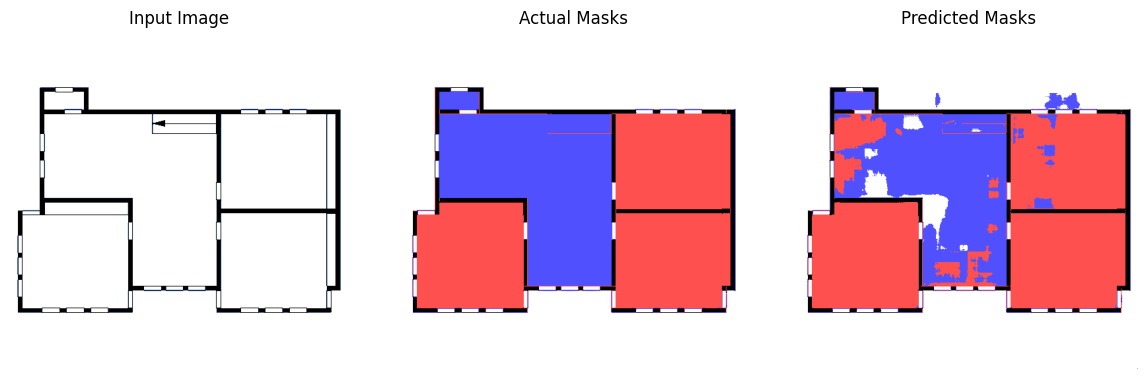

In [35]:
# Model-1

plot_segmentation(
    model=model1, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='model1_seg_fig', 
    save_format='png', 
    close_img=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


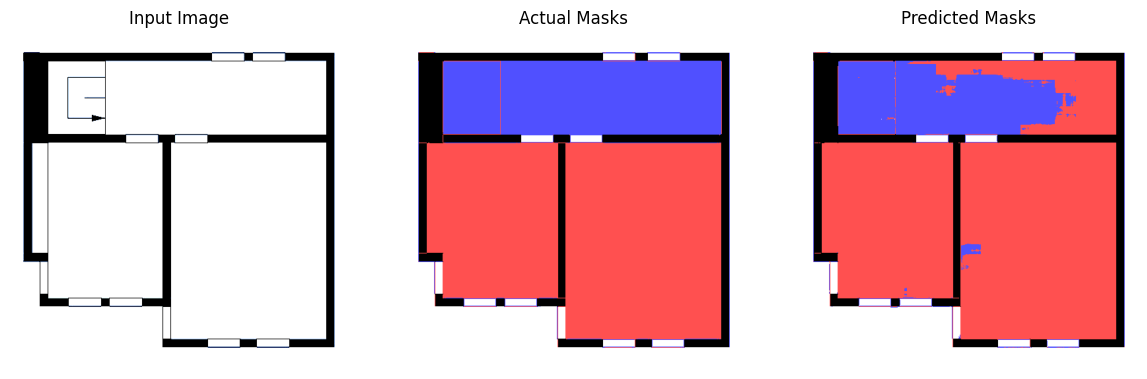

In [36]:
# Model-2

plot_segmentation(
    model=model2, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='model2_seg_fig', 
    save_format='png', 
    close_img=False
)

## Save Predictions

In [37]:
# Model1 Saving
from utils.visualization_utils import save_pred_masks, visualize_segmentation, plot_segmentation
save_pred_masks(
    model=model1,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model1'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model1,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model1'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

In [38]:
# Model2 Saving

save_pred_masks(
    model=model2,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model2'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model2,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model2'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

## History Graphs

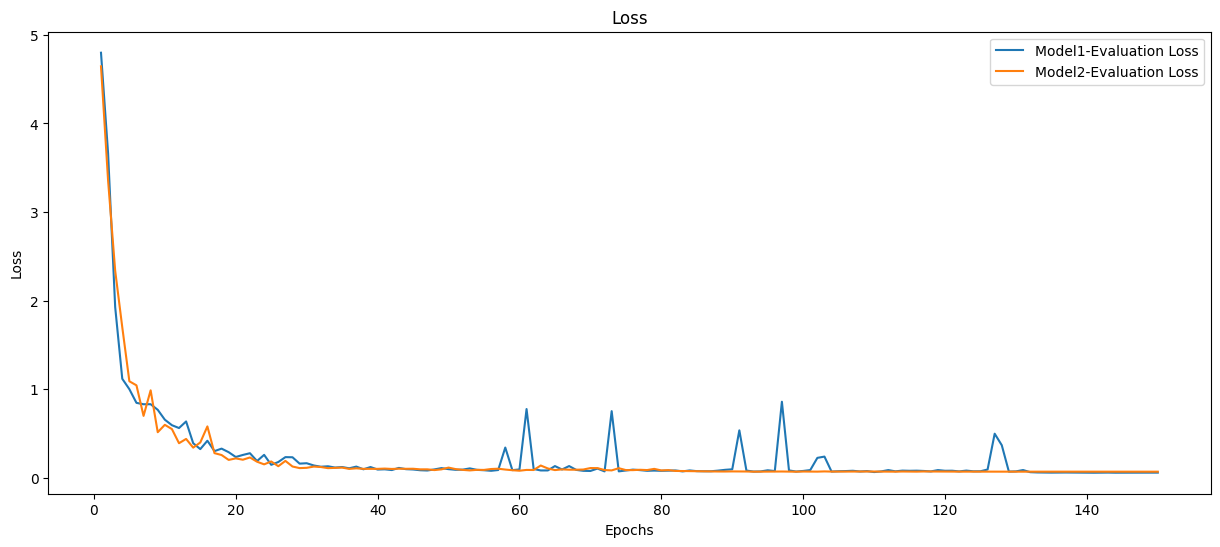

In [39]:
epoch_range = np.arange(1, hyperparameters['epochs']+1, 1, dtype=int)

plt.figure(figsize = (15,6))
plt.title(f"Loss")
plt.plot(epoch_range, history['model1']['eval_loss'], label="Model1-Evaluation Loss")
plt.plot(epoch_range, history['model2']['eval_loss'], label="Model2-Evaluation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
loss_dir = os.path.join(hyperparameters['output_dir']['results'], 'loss_graph.png')
plt.savefig(loss_dir, format='png', bbox_inches='tight')

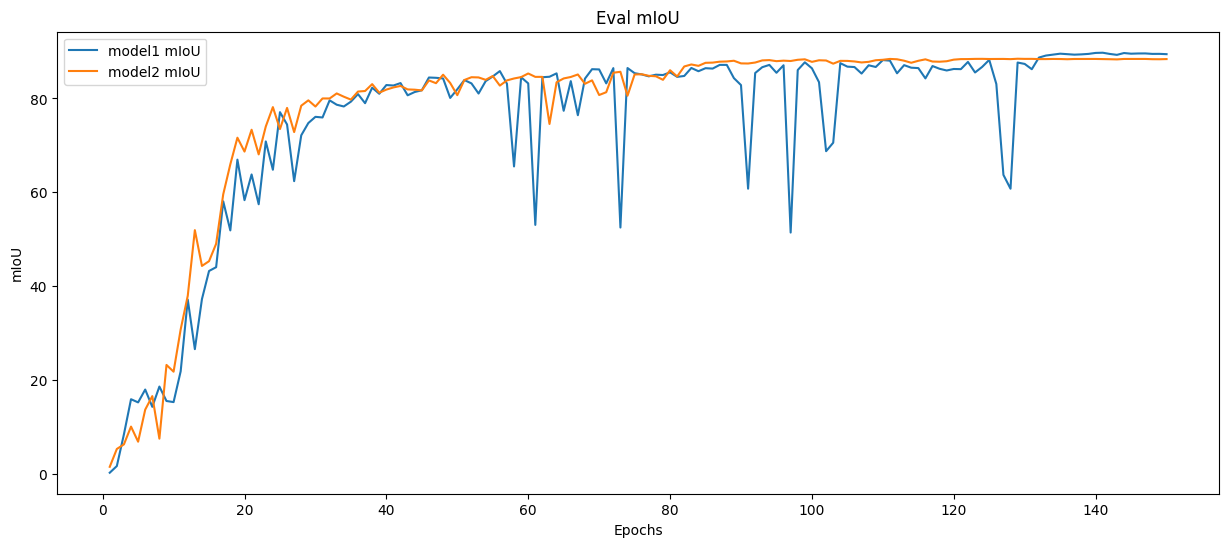

In [40]:
plt.figure(figsize = (15,6))
plt.title(f"Eval mIoU")
plt.plot(epoch_range, history['model1']['eval_miou'], label="model1 mIoU")
plt.plot(epoch_range, history['model2']['eval_miou'], label="model2 mIoU")
plt.xlabel("Epochs")
plt.ylabel("mIoU")
plt.legend();
miou_dir = os.path.join(hyperparameters['output_dir']['results'], 'miou_graph.png')
plt.savefig(miou_dir, format='png', bbox_inches='tight')

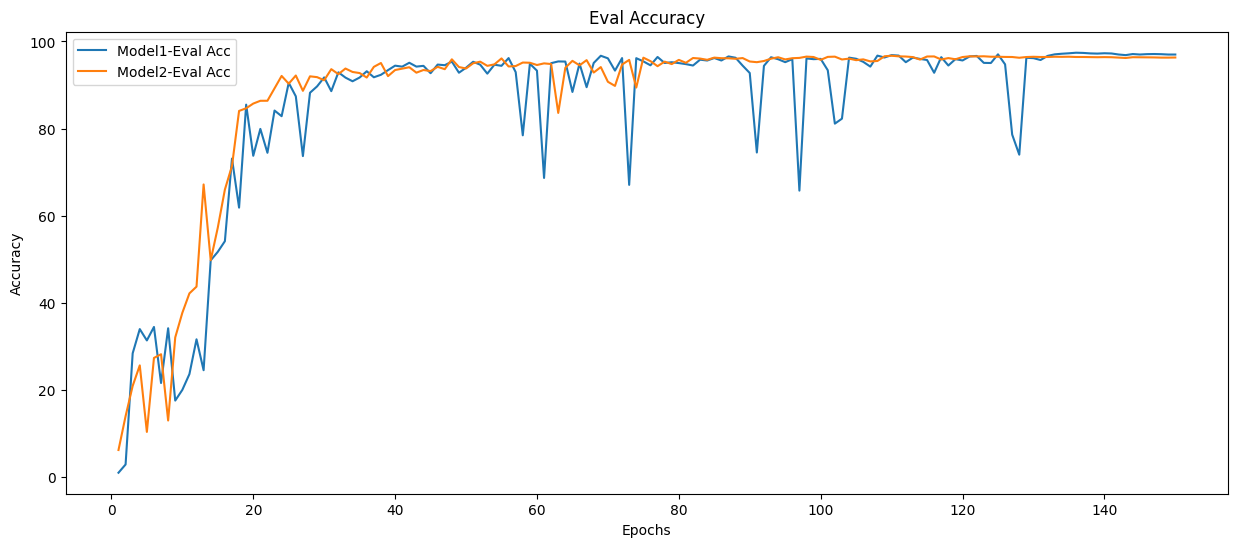

In [41]:
acc_tensor1 = torch.tensor(history['model1']['eval_acc'])
acc_tensor1 = acc_tensor1.to('cpu')
acc_list1 = acc_tensor1.tolist()

acc_tensor2 = torch.tensor(history['model2']['eval_acc'])
acc_tensor2 = acc_tensor2.to('cpu')
acc_list2 = acc_tensor2.tolist()


plt.figure(figsize = (15,6))
plt.title(f"Eval Accuracy")
plt.plot(epoch_range, acc_list1, label="Model1-Eval Acc")
plt.plot(epoch_range, acc_list2, label="Model2-Eval Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
acc_dir = os.path.join(hyperparameters['output_dir']['results'], 'accuracy_graph.png')
plt.savefig(acc_dir, format='png', bbox_inches='tight')